In [1]:
import pandas as pd
import numpy as np

In [216]:
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import math

In [3]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

In [5]:
!dir data

 Volume in drive C is Windows
 Volume Serial Number is 3EE2-6AB7

 Directory of C:\Users\17001970\Documents\Goman\store_prediction\future_sales\data

23/10/2018  20:42    <DIR>          .
23/10/2018  20:42    <DIR>          ..
26/06/2018  07:37         1,568,417 items.csv
26/06/2018  07:37             3,573 item_categories.csv
26/06/2018  07:37        13,515,545 sales_train.csv.gz
26/06/2018  07:37           480,004 sample_submission.csv.gz
26/06/2018  07:37             2,977 shops.csv
26/06/2018  07:37         1,058,887 test.csv.gz
               6 File(s)     16,629,403 bytes
               2 Dir(s)  825,977,057,280 bytes free


In [6]:
items = pd.read_csv('data/items.csv')

In [7]:
items.columns

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

In [8]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
item_categories = pd.read_csv('data/item_categories.csv')

In [10]:
item_categories.columns

Index(['item_category_name', 'item_category_id'], dtype='object')

In [11]:
item_categories.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
sales = pd.read_csv('data/sales_train.csv.gz')

In [13]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [14]:
sales.shape

(2935849, 6)

In [15]:
import datetime

In [16]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [17]:
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [18]:
shops = pd.read_csv('data/shops.csv')

In [19]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.columns

Index(['shop_name', 'shop_id'], dtype='object')

In [21]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# data explore

## Sales

In [22]:
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [23]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [24]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [25]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [26]:
monthly_sales.head(20)

item_cnt_day item_price       date           
                                        sum       mean        min        max
date_block_num shop_id item_id                                              
0              0       32               6.0      221.0 2013-01-03 2013-01-31
                       33               3.0      347.0 2013-01-03 2013-01-28
                       35               1.0      247.0 2013-01-31 2013-01-31
                       43               1.0      221.0 2013-01-31 2013-01-31
                       51               2.0      128.5 2013-01-13 2013-01-31
                       61               1.0      195.0 2013-01-10 2013-01-10
                       75               1.0       76.0 2013-01-17 2013-01-17
                       88               1.0       76.0 2013-01-16 2013-01-16
                       95               1.0      193.0 2013-01-06 2013-01-06
                       96               1.0       70.0 2013-01-10 2013-01-10
                       98              25.0      268.0 2013-01-04 2013-01-31
                       111              1.0       89.0 2013-01-17 2013-01-17
                       149              3.0       99.0 2013-01-11 2013-01-28
                       151              1.0       75.0 2013-01-16 2013-01-16
                       153              1.0      258.0 2013-01-09 2013-01-09
                       198              1.0      112.0 2013-01-10 2013-01-10
                       210              2.0      118.0 2013-01-05 2013-01-25
                       282              1.0      109.0 2013-01-04 2013-01-04
                       306              1.0       59.0 2013-01-22 2013-01-22
                       351              1.0       89.0 2013-01-21 2013-01-21

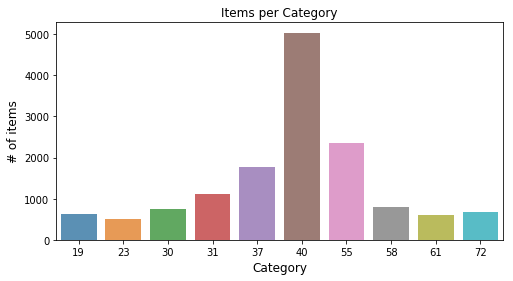

In [27]:
# number of items per cat 
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [28]:
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


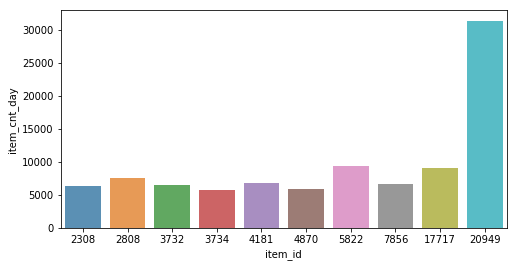

In [29]:
x=sales.groupby(['item_id']).count()
x=x.sort_values(by='item_cnt_day',ascending=False)
x=x.iloc[0:10].reset_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_id, x.item_cnt_day, alpha=0.8)


Let's assume that the 20949 product 

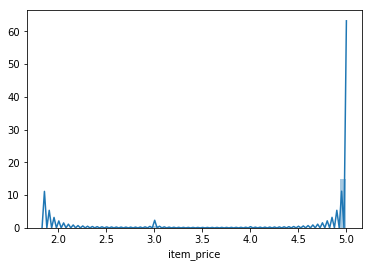

In [30]:
sns.distplot(sales[sales.item_id==20949]['item_price'],);

So the price of the most bought product is not affected to # of buy

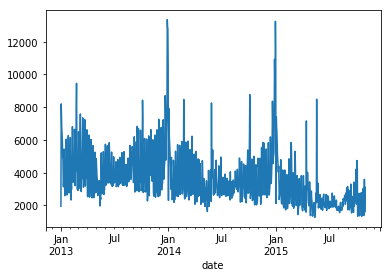

In [31]:
sales.groupby(['date'])['item_cnt_day'].sum().plot()

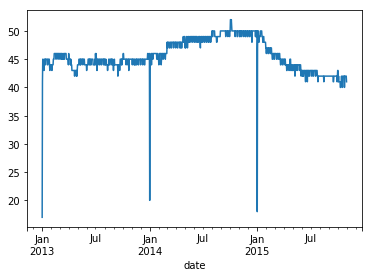

In [32]:
sales.groupby(['date',])['shop_id'].nunique().plot()

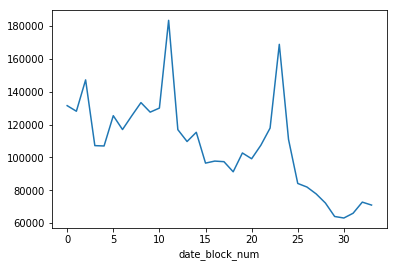

In [33]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.plot()

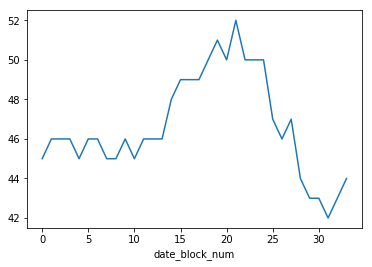

In [34]:
sales.groupby(['date_block_num',])['shop_id'].nunique().plot()

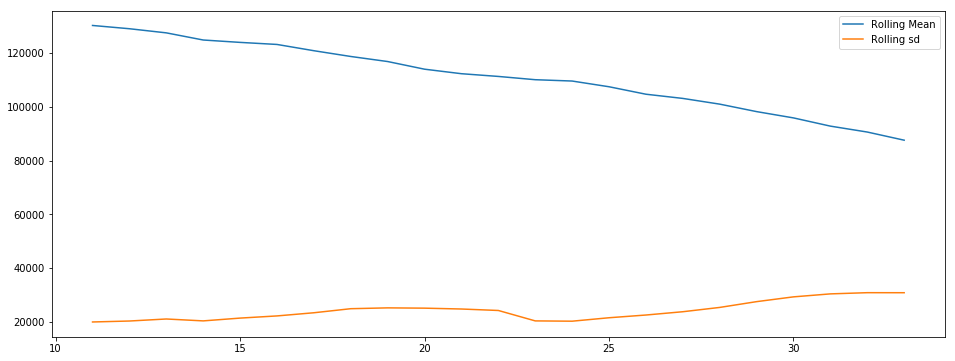

In [35]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

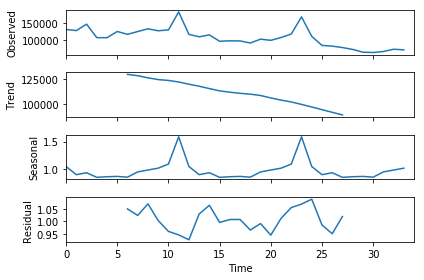

In [75]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()

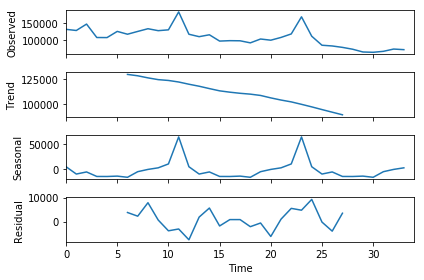

In [79]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
# plt.figure(figsize=(16,12))
fig = res.plot()
# fig.show()

## See how previous month affect sales

In [36]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

Evaluation Data

In [632]:
max_num = sales['date_block_num'].max()
eval_data = sales[sales['date_block_num'] == max_num]
eval_data = eval_data.groupby(['shop_id','item_id']).agg({"item_price":'mean',"item_cnt_day":"sum"})
eval_data['shop_id'] = [i[0] for i in eval_data.index]
eval_data['item_id'] = [i[1] for i in eval_data.index]

In [633]:
eval_data.to_csv('./data/eval.csv', index=False)

Test Data

In [634]:
curr = max_num -1 
test_data = sales[sales['date_block_num'] == max_num]
test_data = test_data.groupby(['shop_id','item_id']).agg({"item_price":'mean',"item_cnt_day":"sum"})
test_data['shop_id'] = [i[0] for i in test_data.index]
test_data['item_id'] = [i[1] for i in test_data.index]

In [635]:
test_data.to_csv('./data/test.csv', index=False)

Training Data

In [636]:
curr = max_num -1 
last_sales =  sales[sales['date_block_num'] == curr]
last_sales = last_sales.groupby(['shop_id','item_id']).agg({"item_price":'mean',"item_cnt_day":"sum"})
last_sales['shop_id'] = [i[0] for i in last_sales.index]
last_sales['item_id'] = [i[1] for i in last_sales.index]

for i in range(1,max_num+1):
    previous_sales = sales.copy()
    previous_sales = previous_sales[['date_block_num', 'shop_id', 'item_id', 'item_price','item_cnt_day']]
    previous_sales = previous_sales[previous_sales['date_block_num'] == curr - 1]
    col_item_price = 'block_%s_lag_%s_item_price' % (curr-1, i)
    col_item_cnt_day = 'block_%s_lag_%s_item_cnt_day' % (curr-1, i)
    previous_sales[col_item_price] = previous_sales['item_price']
    previous_sales[col_item_cnt_day] = previous_sales['item_cnt_day']
    
    previous_sales= previous_sales.groupby(['shop_id','item_id']).agg({col_item_price:'mean', col_item_cnt_day:"sum"})
    previous_sales['shop_id'] = [i[0] for i in previous_sales.index]
    previous_sales['item_id'] = [i[1] for i in previous_sales.index]

    last_sales = pd.merge(last_sales, previous_sales, on=['shop_id', 'item_id'], how='left')
    curr = curr - 1

In [637]:
cols = []
for col in last_sales.columns:
    if 'tuple' in str(type(col)):
        cols.append(col[0]+"_"+col[1])
    else:
        cols.append(col)

In [638]:
last_sales.columns = cols

In [639]:
last_sale_clear_nan = last_sales.fillna(0)

In [640]:
last_sale_clear_nan.head(5)

,item_cnt_day,item_price,shop_id,item_id,block_31_lag_1_item_price,block_31_lag_1_item_cnt_day,block_30_lag_2_item_cnt_day,block_30_lag_2_item_price,block_29_lag_3_item_cnt_day,block_29_lag_3_item_price,...,block_3_lag_29_item_cnt_day,block_3_lag_29_item_price,block_2_lag_30_item_price,block_2_lag_30_item_cnt_day,block_1_lag_31_item_price,block_1_lag_31_item_cnt_day,block_0_lag_32_item_cnt_day,block_0_lag_32_item_price,block_-1_lag_33_item_cnt_day,block_-1_lag_33_item_price
0,1.0,199.0,2,33,0.0,0.0,1.0,199.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,499.0,0.0,0.0
1,1.0,300.0,2,486,0.0,0.0,0.0,0.0,2.0,300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,979.0,2,792,979.0,2.0,0.0,0.0,1.0,979.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,349.0,2,975,0.0,0.0,1.0,349.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,499.0,2,1090,0.0,0.0,0.0,0.0,1.0,499.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [641]:
col_cnt = []
for c in last_sale_clear_nan.columns:
    if 'item_cnt_day' in c:
        col_cnt.append(c)

## little feature analysis

In [642]:
last_sale_clear_nan.head(5)

,item_cnt_day,item_price,shop_id,item_id,block_31_lag_1_item_price,block_31_lag_1_item_cnt_day,block_30_lag_2_item_cnt_day,block_30_lag_2_item_price,block_29_lag_3_item_cnt_day,block_29_lag_3_item_price,...,block_3_lag_29_item_cnt_day,block_3_lag_29_item_price,block_2_lag_30_item_price,block_2_lag_30_item_cnt_day,block_1_lag_31_item_price,block_1_lag_31_item_cnt_day,block_0_lag_32_item_cnt_day,block_0_lag_32_item_price,block_-1_lag_33_item_cnt_day,block_-1_lag_33_item_price
0,1.0,199.0,2,33,0.0,0.0,1.0,199.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,499.0,0.0,0.0
1,1.0,300.0,2,486,0.0,0.0,0.0,0.0,2.0,300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,979.0,2,792,979.0,2.0,0.0,0.0,1.0,979.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,349.0,2,975,0.0,0.0,1.0,349.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,499.0,2,1090,0.0,0.0,0.0,0.0,1.0,499.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [643]:
last_buy = []
average_interval = []

for items in last_sale_clear_nan[col_cnt].values:
    month = -1
    month_interval = []
    last_buy_month = 0
    for idx,row in enumerate(items):
        if idx > 0 and row > 0:
            if month == -1:
                month = idx
            month_interval.append(idx - last_buy_month)
            last_buy_month = idx
    last_buy.append(month)
    average_interval.append(np.mean(month_interval))
last_sale_clear_nan['last_buy'] = last_buy
last_sale_clear_nan['average_interval'] = average_interval
last_sale_clear_nan['avg_buy_rate'] = last_sale_clear_nan[col_cnt].mean(axis=1)
last_sale_clear_nan['std_buy_rate'] = last_sale_clear_nan[col_cnt].std(axis=1)

In [644]:
last_sale_clear_nan.to_csv('./data/train.csv', index=False)

In [619]:
feat = [
       'block_31_lag_1_item_price', 'block_31_lag_1_item_cnt_day',
       'block_30_lag_2_item_cnt_day', 'block_30_lag_2_item_price',
       'block_29_lag_3_item_cnt_day', 'block_29_lag_3_item_price',
       'block_28_lag_4_item_cnt_day', 'block_28_lag_4_item_price',
       'block_27_lag_5_item_cnt_day', 'block_27_lag_5_item_price',
       'block_26_lag_6_item_price', 'block_26_lag_6_item_cnt_day',
       'block_25_lag_7_item_price', 'block_25_lag_7_item_cnt_day',
       'block_24_lag_8_item_price', 'block_24_lag_8_item_cnt_day',
       'block_23_lag_9_item_cnt_day', 'block_23_lag_9_item_price',
       'block_22_lag_10_item_price', 'block_22_lag_10_item_cnt_day',
       'block_21_lag_11_item_price', 'block_21_lag_11_item_cnt_day',
       'block_20_lag_12_item_cnt_day', 'block_20_lag_12_item_price',
       'block_19_lag_13_item_cnt_day', 'block_19_lag_13_item_price',
       'block_18_lag_14_item_price', 'block_18_lag_14_item_cnt_day',
       'block_17_lag_15_item_cnt_day', 'block_17_lag_15_item_price',
       'block_16_lag_16_item_price', 'block_16_lag_16_item_cnt_day',
       'block_15_lag_17_item_price', 'block_15_lag_17_item_cnt_day',
       'block_14_lag_18_item_price', 'block_14_lag_18_item_cnt_day',
       'block_13_lag_19_item_cnt_day', 'block_13_lag_19_item_price',
       'block_12_lag_20_item_cnt_day', 'block_12_lag_20_item_price',
       'block_11_lag_21_item_price', 'block_11_lag_21_item_cnt_day',
       'block_10_lag_22_item_price', 'block_10_lag_22_item_cnt_day',
       'block_9_lag_23_item_price', 'block_9_lag_23_item_cnt_day',
       'block_8_lag_24_item_cnt_day', 'block_8_lag_24_item_price',
       'block_7_lag_25_item_price', 'block_7_lag_25_item_cnt_day',
       'block_6_lag_26_item_cnt_day', 'block_6_lag_26_item_price',
       'block_5_lag_27_item_cnt_day', 'block_5_lag_27_item_price',
       'block_4_lag_28_item_price', 'block_4_lag_28_item_cnt_day',
       'block_3_lag_29_item_cnt_day', 'block_3_lag_29_item_price',
       'block_2_lag_30_item_price', 'block_2_lag_30_item_cnt_day',
       'block_1_lag_31_item_price', 'block_1_lag_31_item_cnt_day',
       'block_0_lag_32_item_cnt_day', 'block_0_lag_32_item_price',
       'avg_buy_rate', 'std_buy_rate','item_cnt_day', 'item_price',
        'last_buy','average_interval', 
        'item_cnt_day', 'item_price']

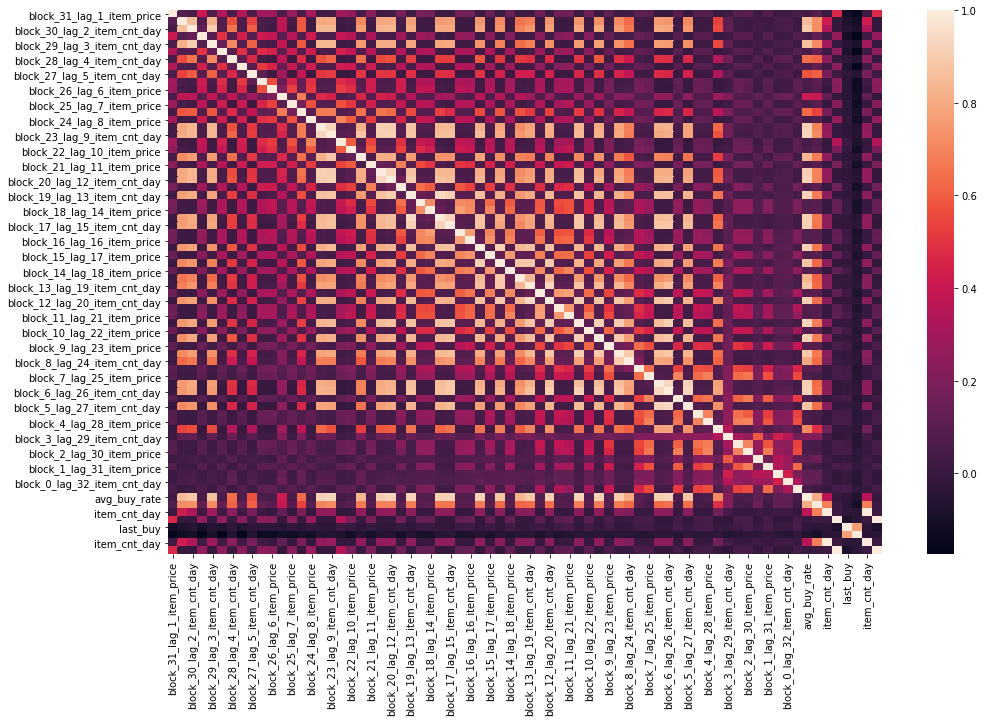

In [620]:
plt.figure(figsize = (16,10))
sns.heatmap(last_sale_clear_nan[feat].corr())

## Modelling

In [621]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb

In [622]:
from lightgbm import plot_importance

In [623]:
lr = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.3, n_estimators=1000, colsample_bytree=0.8,
                       min_child_weight=300,
                       max_depth=8,
                       subsample=0.8,
                       seed=42
                      )

In [624]:
lr.fit(last_sale_clear_nan[feat], last_sale_clear_nan['item_cnt_day'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       importance_type='split', learning_rate=0.3, max_depth=8,
       min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=0.8, subsample_for_bin=200000,
       subsample_freq=0)

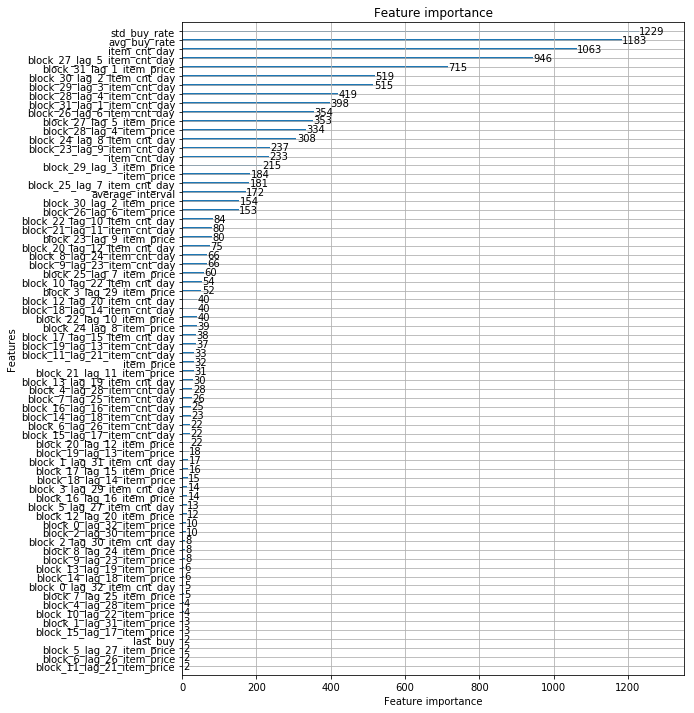

In [625]:
fig, ax = plt.subplots(figsize=(9, 12))
plot_importance(lr, ax=ax)

In [548]:
pred = lr.predict(last_sale_clear_nan[feat])

In [549]:
last_sale_clear_nan['predictions'] = pred

In [550]:
res = pd.merge(eval_data, last_sale_clear_nan[['shop_id','item_id', 'predictions']], on=['shop_id','item_id'], how='left')

In [551]:
print(mean_absolute_error(res['item_cnt_day'], res['predictions']))
print(math.sqrt(mean_squared_error(res['item_cnt_day'], res['predictions'])))

0.6464847079194752
7.94965221047622


# Test

In [552]:
test = pd.read_csv('data/test.csv.gz')

In [553]:
import seaborn as sns

In [556]:
max_num = sales['date_block_num'].max()
last_sales=  sales[sales['date_block_num'] == max_num]
last_sales= last_sales.groupby(['shop_id','item_id']).agg({"item_price":'mean',"item_cnt_day":"sum"})
last_sales['shop_id'] = [i[0] for i in last_sales.index]
last_sales['item_id'] = [i[1] for i in last_sales.index]

curr = max_num

for i in range(1,max_num+1):
    previous_sales = sales.copy()
    previous_sales = previous_sales[['date_block_num', 'shop_id', 'item_id', 'item_price','item_cnt_day']]
    previous_sales = previous_sales[previous_sales['date_block_num'] == curr - 1]
    col_item_price = 'block_%s_lag_%s_item_price' % (curr-1, i)
    col_item_cnt_day = 'block_%s_lag_%s_item_cnt_day' % (curr-1, i)
    previous_sales[col_item_price] = previous_sales['item_price']
    previous_sales[col_item_cnt_day] = previous_sales['item_cnt_day']
    
    previous_sales= previous_sales.groupby(['shop_id','item_id']).agg({col_item_price:'mean', col_item_cnt_day:"sum"})
    previous_sales['shop_id'] = [i[0] for i in previous_sales.index]
    previous_sales['item_id'] = [i[1] for i in previous_sales.index]

    last_sales = pd.merge(last_sales, previous_sales, on=['shop_id', 'item_id'], how='left')
    curr = curr - 1

In [557]:
last_buy = []
average_interval = []

for items in last_sale_clear_nan[col_cnt].values:
    month = -1
    month_interval = []
    last_buy_month = 0
    for idx,row in enumerate(items):
        if idx > 0 and row > 0:
            if month == -1:
                month = idx
            month_interval.append(idx - last_buy_month)
            last_buy_month = idx
    last_buy.append(month)
    average_interval.append(np.mean(month_interval))
last_sale_clear_nan['last_buy'] = last_buy
last_sale_clear_nan['average_interval'] = average_interval
last_sale_clear_nan['avg_buy_rate'] = last_sale_clear_nan[col_cnt].mean(axis=1)
last_sale_clear_nan['std_buy_rate'] = last_sale_clear_nan[col_cnt].std(axis=1)

In [580]:
feat = ['item_cnt_day', 'item_price', 
       'block_31_lag_1_item_price', 'block_31_lag_1_item_cnt_day',
       'block_30_lag_2_item_cnt_day', 'block_30_lag_2_item_price',
       'block_29_lag_3_item_cnt_day', 'block_29_lag_3_item_price',
       'block_28_lag_4_item_cnt_day', 'block_28_lag_4_item_price',
       'block_27_lag_5_item_cnt_day', 'block_27_lag_5_item_price',
       'block_26_lag_6_item_price', 'block_26_lag_6_item_cnt_day',
       'block_25_lag_7_item_price', 'block_25_lag_7_item_cnt_day',
       'block_24_lag_8_item_price', 'block_24_lag_8_item_cnt_day',
       'block_23_lag_9_item_cnt_day', 'block_23_lag_9_item_price',
       'block_22_lag_10_item_price', 'block_22_lag_10_item_cnt_day',
       'block_21_lag_11_item_price', 'block_21_lag_11_item_cnt_day',
       'block_20_lag_12_item_cnt_day', 'block_20_lag_12_item_price',
       'block_19_lag_13_item_cnt_day', 'block_19_lag_13_item_price',
       'block_18_lag_14_item_price', 'block_18_lag_14_item_cnt_day',
       'block_17_lag_15_item_cnt_day', 'block_17_lag_15_item_price',
       'block_16_lag_16_item_price', 'block_16_lag_16_item_cnt_day',
       'block_15_lag_17_item_price', 'block_15_lag_17_item_cnt_day',
       'block_14_lag_18_item_price', 'block_14_lag_18_item_cnt_day',
       'block_13_lag_19_item_cnt_day', 'block_13_lag_19_item_price',
       'block_12_lag_20_item_cnt_day', 'block_12_lag_20_item_price',
       'block_11_lag_21_item_price', 'block_11_lag_21_item_cnt_day',
       'block_10_lag_22_item_price', 'block_10_lag_22_item_cnt_day',
       'block_9_lag_23_item_price', 'block_9_lag_23_item_cnt_day',
       'block_8_lag_24_item_cnt_day', 'block_8_lag_24_item_price',
       'block_7_lag_25_item_price', 'block_7_lag_25_item_cnt_day',
       'block_6_lag_26_item_cnt_day', 'block_6_lag_26_item_price',
       'block_5_lag_27_item_cnt_day', 'block_5_lag_27_item_price',
       'block_4_lag_28_item_price', 'block_4_lag_28_item_cnt_day',
       'block_3_lag_29_item_cnt_day', 'block_3_lag_29_item_price',
       'block_2_lag_30_item_price', 'block_2_lag_30_item_cnt_day',
       'block_1_lag_31_item_price', 'block_1_lag_31_item_cnt_day',
       'block_0_lag_32_item_cnt_day', 'block_0_lag_32_item_price',
       'avg_buy_rate', 'std_buy_rate', 'predictions', ]

In [581]:
lr.fit(last_sale_clear_nan[feat], last_sale_clear_nan['item_cnt_day'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       importance_type='split', learning_rate=0.3, max_depth=8,
       min_child_samples=20, min_child_weight=300, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=0.8, subsample_for_bin=200000,
       subsample_freq=0)

In [582]:
last_sale_clear_nan['predictions'] = lr.predict(last_sale_clear_nan[feat])

In [583]:
submission = pd.merge(test, last_sale_clear_nan[['shop_id','item_id', 'predictions']], on=['shop_id','item_id'], how='left')

In [584]:
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Submission

In [585]:
sample_submission = pd.read_csv('data/sample_submission.csv.gz')

In [586]:
sample_submission.head(5)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [587]:
submission['item_cnt_month'] = submission['predictions']

In [588]:
submission = submission.fillna(0)

In [589]:
submission[['ID','item_cnt_month']].head(5)

,ID,item_cnt_month
0,0,0.000000
1,1,0.000000
2,2,0.994774
3,3,0.000000
4,4,0.000000


In [591]:
submission[['ID','item_cnt_month']].to_csv('data/submission_4.csv', index=False)